Step 4: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product

In [ ]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas , also different number of users each day (?)
#uncertain number of items sold per product
#uncertain conversion rates

#item sold : reward prodotto giornaliero/numero click

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.TS_Learner import *
from Algorithms.UCB_Learner import *

In [3]:
P1 = Product(0,[9,12,13,14.5],[ 1.,  4,  5., 6.5])
P2 = Product(1,[20,22.5,23,24.5],[ 4.,  6.5, 7., 8.5])
P3 = Product(2,[30,31.5,34,34.5],[ 6.,  7.5, 10., 10.5])
P4 = Product(3,[40,42.5,43,46.5],[ 8., 10.5, 11., 14.5])
P5 = Product(4,[50,51.5,53,54.5],[10., 11.5, 13., 14.5])

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])
E.set_products(products)
E.set_lambda(0.5)

In [6]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
binary_vector = np.array([127,0]) 
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha, fixed_weights)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])  
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i])

    conv_rates_per_experiment.append(conversion_rates)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) + np.std(opt_vector)**2
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i])
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.69021141 0.16004519 0.06709351 0.01210134]
 [0.93041883 0.59918534 0.5010236  0.22787465]
 [0.99269393 0.96013357 0.69311394 0.59507306]
 [0.68999054 0.22479565 0.15828465 0.00339425]
 [0.97449611 0.89228887 0.69045414 0.40271168]]
_______________________________________________
Expected rewards per arm
[[0.69403233 0.55170014 0.2697284  0.05939488]
 [3.68953231 3.44548281 2.92669137 1.49942743]
 [5.92214581 6.12905869 5.67996217 5.00971001]
 [5.47301366 2.08071835 1.41736477 0.03917876]
 [9.22237457 8.34236884 7.0895102  4.62003814]]
_______________________________________________
Best configuration [0. 1. 1. 0. 1.]
Optimal cumulative expected reward per round
27.57054173835198


In [7]:
#Comparison between TS and UCB

n_arms = 4
num_users = 100
binary_vector = np.array([127,0]) 
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
n_experiments = 10

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gr_rewards_per_experiment = []
cr_rewards_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha,fixed_weights)
    gr_learner = Greedy(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    ts_learner = TS(n_arms=n_arms)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)

        pulled_arm = gr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)  

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)
    cr_rewards_per_experiment.append(cr_learner.collected_rewards)


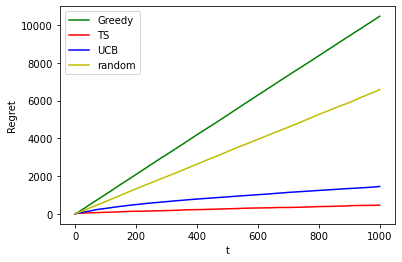

In [8]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - cr_rewards_per_experiment, axis=0)), 'y')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

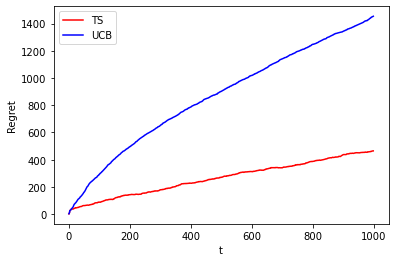

In [9]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["TS","UCB"])
plt.show()

In [12]:
print("_______________________________________________")
print("TS Total collected reward")
print(np.sum(np.mean(ts_rewards_per_experiment,axis=0)))
print("UCB Total collected reward")
print(np.sum(np.mean(ucb_rewards_per_experiment,axis=0)))
print("_______________________________________________")

print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("UCB",np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))
print("UCB",np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))

_______________________________________________
TS Total collected reward
27105.6926975063
UCB Total collected reward
26116.882339450247
_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 1000 days and its standard deviation considering 10 experiments
TS 27105.6926975063 79.5387837205946
UCB 26116.882339450247 208.38339796698085
-----------------------------------------------
Total expected regret over 1000 days and its standard deviation considering 10 experiments
TS 464.84904084568353 79.53878372059519
UCB 1453.6593989017333 208.38339796698028
-----------------------------------------------
Average expected reward per round over 1000 days and its standard deviation between the rounds considering 10 experiments
TS 27.1056926975063 0.9429824592641722
UCB 26.116882339450246 1.0940543976258623
-----------------------------------------------
Average expected regret per round over 1000 

In [13]:
print("_______________________________________________")
print("TS Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ts_learner.rewards_per_arm[i][0])-1,len(ts_learner.rewards_per_arm[i][1])-1,len(ts_learner.rewards_per_arm[i][2])-1,len(ts_learner.rewards_per_arm[i][3])-1]
    print(pulls_per_arm)
print("UCB Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ucb_learner.rewards_per_arm[i][0])-1,len(ucb_learner.rewards_per_arm[i][1])-1,len(ucb_learner.rewards_per_arm[i][2])-1,len(ucb_learner.rewards_per_arm[i][3])-1]
    print(pulls_per_arm)

_______________________________________________
TS Pulls per arm for the last experiment
[898, 96, 3, 3]
[15, 976, 7, 2]
[1, 969, 19, 11]
[995, 2, 1, 2]
[11, 971, 15, 3]
UCB Pulls per arm for the last experiment
[942, 26, 20, 12]
[808, 121, 52, 19]
[194, 714, 68, 24]
[947, 20, 20, 13]
[541, 418, 29, 12]


In [14]:
#Comparison between TS and UCB with respect to the number of users per round

n_arms = 4
num_users = 10
binary_vector = np.array([127,0]) 
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
n_experiments = 3

ts_rewards_per_experiment_10 = []
ucb_rewards_per_experiment_10 = []

ts_rewards_per_experiment_100 = []
ucb_rewards_per_experiment_100 = []


ts_rewards_per_experiment_1000 = []
ucb_rewards_per_experiment_1000 = []


for e in range(n_experiments):

    env_10 = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha, fixed_weights)
    ucb_learner_10 = UCB(n_arms=n_arms)
    ts_learner_10 = TS(n_arms=n_arms)

    env_100 = Environment(n_arms, E, margins_matrix, num_users*10, binary_vector, fixed_alpha, fixed_weights)
    ucb_learner_100 = UCB(n_arms=n_arms)
    ts_learner_100 = TS(n_arms=n_arms)

    env_1000 = Environment(n_arms, E, margins_matrix, num_users*100, binary_vector, fixed_alpha, fixed_weights)
    ucb_learner_1000 = UCB(n_arms=n_arms)
    ts_learner_1000 = TS(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner_10.pull_arm()
        reward = env_10.round(pulled_arm)
        ucb_learner_10.update(pulled_arm, reward)

        pulled_arm = ucb_learner_100.pull_arm()
        reward = env_100.round(pulled_arm)
        ucb_learner_100.update(pulled_arm, reward)

        pulled_arm = ucb_learner_1000.pull_arm()
        reward = env_1000.round(pulled_arm)
        ucb_learner_1000.update(pulled_arm, reward)
        
        pulled_arm = ts_learner_10.pull_arm(env_10.margins_matrix)
        reward = env_10.round(pulled_arm)
        ts_learner_10.update(pulled_arm, reward, env_10.clicks_current_day, env_10.purchases_current_day)

        pulled_arm = ts_learner_100.pull_arm(env_100.margins_matrix)
        reward = env_100.round(pulled_arm)
        ts_learner_100.update(pulled_arm, reward, env_100.clicks_current_day, env_100.purchases_current_day)

        pulled_arm = ts_learner_1000.pull_arm(env_1000.margins_matrix)
        reward = env_1000.round(pulled_arm)
        ts_learner_1000.update(pulled_arm, reward, env_1000.clicks_current_day, env_1000.purchases_current_day)

    ts_rewards_per_experiment_10.append(ts_learner_10.collected_rewards)
    ucb_rewards_per_experiment_10.append(ucb_learner_10.collected_rewards)

    
    ts_rewards_per_experiment_100.append(ts_learner_100.collected_rewards)
    ucb_rewards_per_experiment_100.append(ucb_learner_100.collected_rewards)

    
    ts_rewards_per_experiment_1000.append(ts_learner_1000.collected_rewards)
    ucb_rewards_per_experiment_1000.append(ucb_learner_1000.collected_rewards)


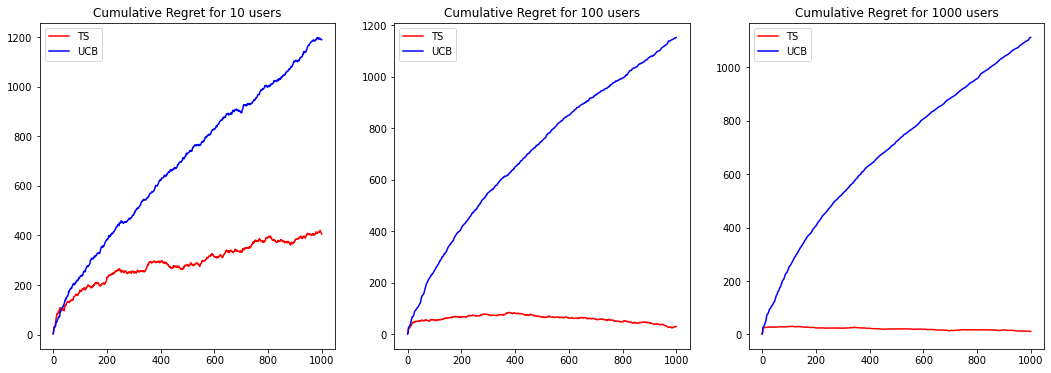

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()